In [1]:
import psycopg2
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
import configparser
import warnings
warnings.filterwarnings('ignore')

# **CONNECTING TO DATABASE AND FETCHING DATA**

In [2]:
def fetch_data():
    config = configparser.ConfigParser()
    config.read('db_config.ini')

    host = config['database']['host']
    port = config['database'].getint('port')
    user = config['database']['user']
    password = config['database']['password']
    database = config['database']['database']

    connection = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=database
    )

    df1 = pd.read_sql('SELECT * FROM turbofan_engine_data', con=connection)
    df2 = pd.read_sql('SELECT * FROM turbofan_rul_data', con=connection)

    connection.close()

    return df1, df2

In [3]:
df1, df2 = fetch_data()

# **SPLITTING DATA**

In [4]:
train_df = df1[df1["source"] == 0].copy()

In [5]:
test_df = df1[df1["source"] == 1].copy()

# **DERIVING RUL COLUMN**

In [6]:
def add_rul_train(df):

    max_cycles_train = df.groupby('engine')['cycle'].max().reset_index()
    max_cycles_train.columns = ['engine', 'max_cycle_train']

    df = df.merge(max_cycles_train, on='engine', how='left')

    df['RUL'] = df['max_cycle_train'] - df['cycle']

    df.drop(['max_cycle_train'], axis=1, inplace=True)

    with pd.option_context('display.max_rows', None):
        print(df[['index', 'engine', 'RUL']].head(350))

    return df

In [7]:
def add_rul_test(df, external_rul_df):

    external_rul_df = external_rul_df.copy()
    df = df.merge(external_rul_df[['engine', 'RUL']], on='engine', how='left')

    with pd.option_context('display.max_rows', None):
        print(df[['index', 'engine', 'RUL']].head(250))

    return df

In [8]:
train_df_with_rul = add_rul_train(train_df)
test_df_with_rul = add_rul_test(test_df, df2)

     index  engine    RUL
0        1     1.0  148.0
1        2     1.0  147.0
2        3     1.0  146.0
3        4     1.0  145.0
4        5     1.0  144.0
5        6     1.0  143.0
6        7     1.0  142.0
7        8     1.0  141.0
8        9     1.0  140.0
9       10     1.0  139.0
10      11     1.0  138.0
11      12     1.0  137.0
12      13     1.0  136.0
13      14     1.0  135.0
14      15     1.0  134.0
15      16     1.0  133.0
16      17     1.0  132.0
17      18     1.0  131.0
18      19     1.0  130.0
19      20     1.0  129.0
20      21     1.0  128.0
21      22     1.0  127.0
22      23     1.0  126.0
23      24     1.0  125.0
24      25     1.0  124.0
25      26     1.0  123.0
26      27     1.0  122.0
27      28     1.0  121.0
28      29     1.0  120.0
29      30     1.0  119.0
30      31     1.0  118.0
31      32     1.0  117.0
32      33     1.0  116.0
33      34     1.0  115.0
34      35     1.0  114.0
35      36     1.0  113.0
36      37     1.0  112.0
37      38  

In [9]:
train_df_with_rul.shape

(53759, 29)

In [10]:
train_df_with_rul.columns

Index(['index', 'engine', 'cycle', 'source', 'altitude (alt)',
       'mach_number (mach)', 'throttle_resolver_angle (TRA)',
       'fan_inlet_temperature (T2)', 'LPC_outlet_temperature (T24)',
       'HPC_outlet_temperature (T30)', 'LPT_outlet_temperature (T50)',
       'fan_inlet_pressure (P2)', 'bypass_duct_pressure (P15)',
       'fan_speed (Nf)', 'core_speed (Nc)',
       'HPC_outlet_static_pressure (Ps30)', 'HPC_outlet_pressure (P30)',
       'engine_pressure_ratio (epr)', 'fuel_ps30_ratio (phi)',
       'corrected_fan_speed (NRf)', 'corrected_core_speed (NRc)',
       'bypass_ratio (BPR)', 'burner_fuel_air_ratio (farB)',
       'bleed_enthalpy (htBleed)', 'demanded_fan_speed (Nf_dmd)',
       'demanded_corrected_fan_speed (PCNfR_dmd)', 'HPT_coolant_bleed (W31)',
       'LPT_coolant_bleed (W32)', 'RUL'],
      dtype='object')

In [11]:
test_df_with_rul.shape

(33991, 29)

# **EDA**

In [12]:
max_cycles = train_df_with_rul.groupby('engine')['cycle'].max().reset_index()

fig = go.Figure(data=[
    go.Bar(x=max_cycles['engine'], y=max_cycles['cycle'], marker_color='skyblue')
])

fig.update_layout(
    title='Maximum Cycle Time for Each Engine',
    xaxis=dict(title='Engine'),
    yaxis=dict(title='Maximum Cycle Time'),
    xaxis_tickangle=-45,
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False
)

fig.show()

Text(0.5, 9.444444444444459, 'max time cycle')

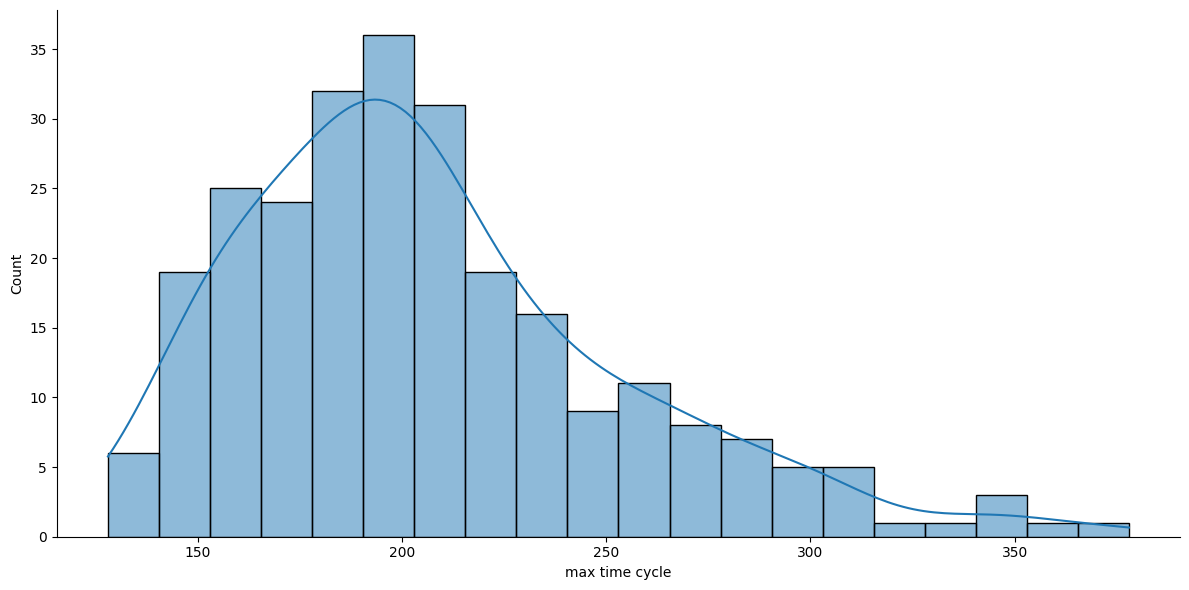

In [13]:
sns.displot(max_cycles['cycle'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Observation : Most engines can achive time cycle between 100 and 200 before system failure.

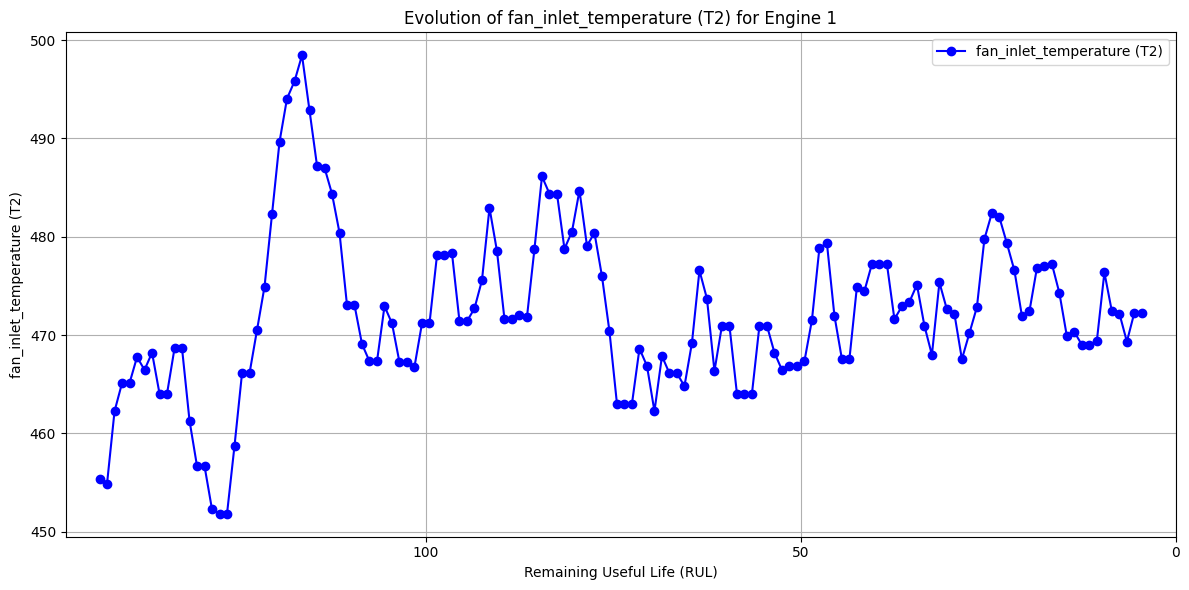

In [14]:
def plot_signal_for_engine(df, engine_id, signal_name):
    plt.figure(figsize=(12, 6))

    # Filter data for the specific engine
    engine_data = df[(df['engine'] == engine_id)]

    # Plot RUL vs. Signal Measurement
    plt.plot('RUL', signal_name, data=engine_data.rolling(10).mean(), linestyle='-', marker='o', color='b', label=signal_name)

    plt.title(f'Evolution of {signal_name} for Engine {engine_id}')
    plt.xlabel('Remaining Useful Life (RUL)')
    plt.ylabel(signal_name)
    plt.xlim(engine_data['RUL'].max(), 0)
    plt.xticks(np.arange(0, engine_data['RUL'].max() + 1, 50))

    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

engine_id = 1
signal_name = 'fan_inlet_temperature (T2)'

plot_signal_for_engine(train_df_with_rul, engine_id, signal_name)

# **CORRELATION ANALYSIS**

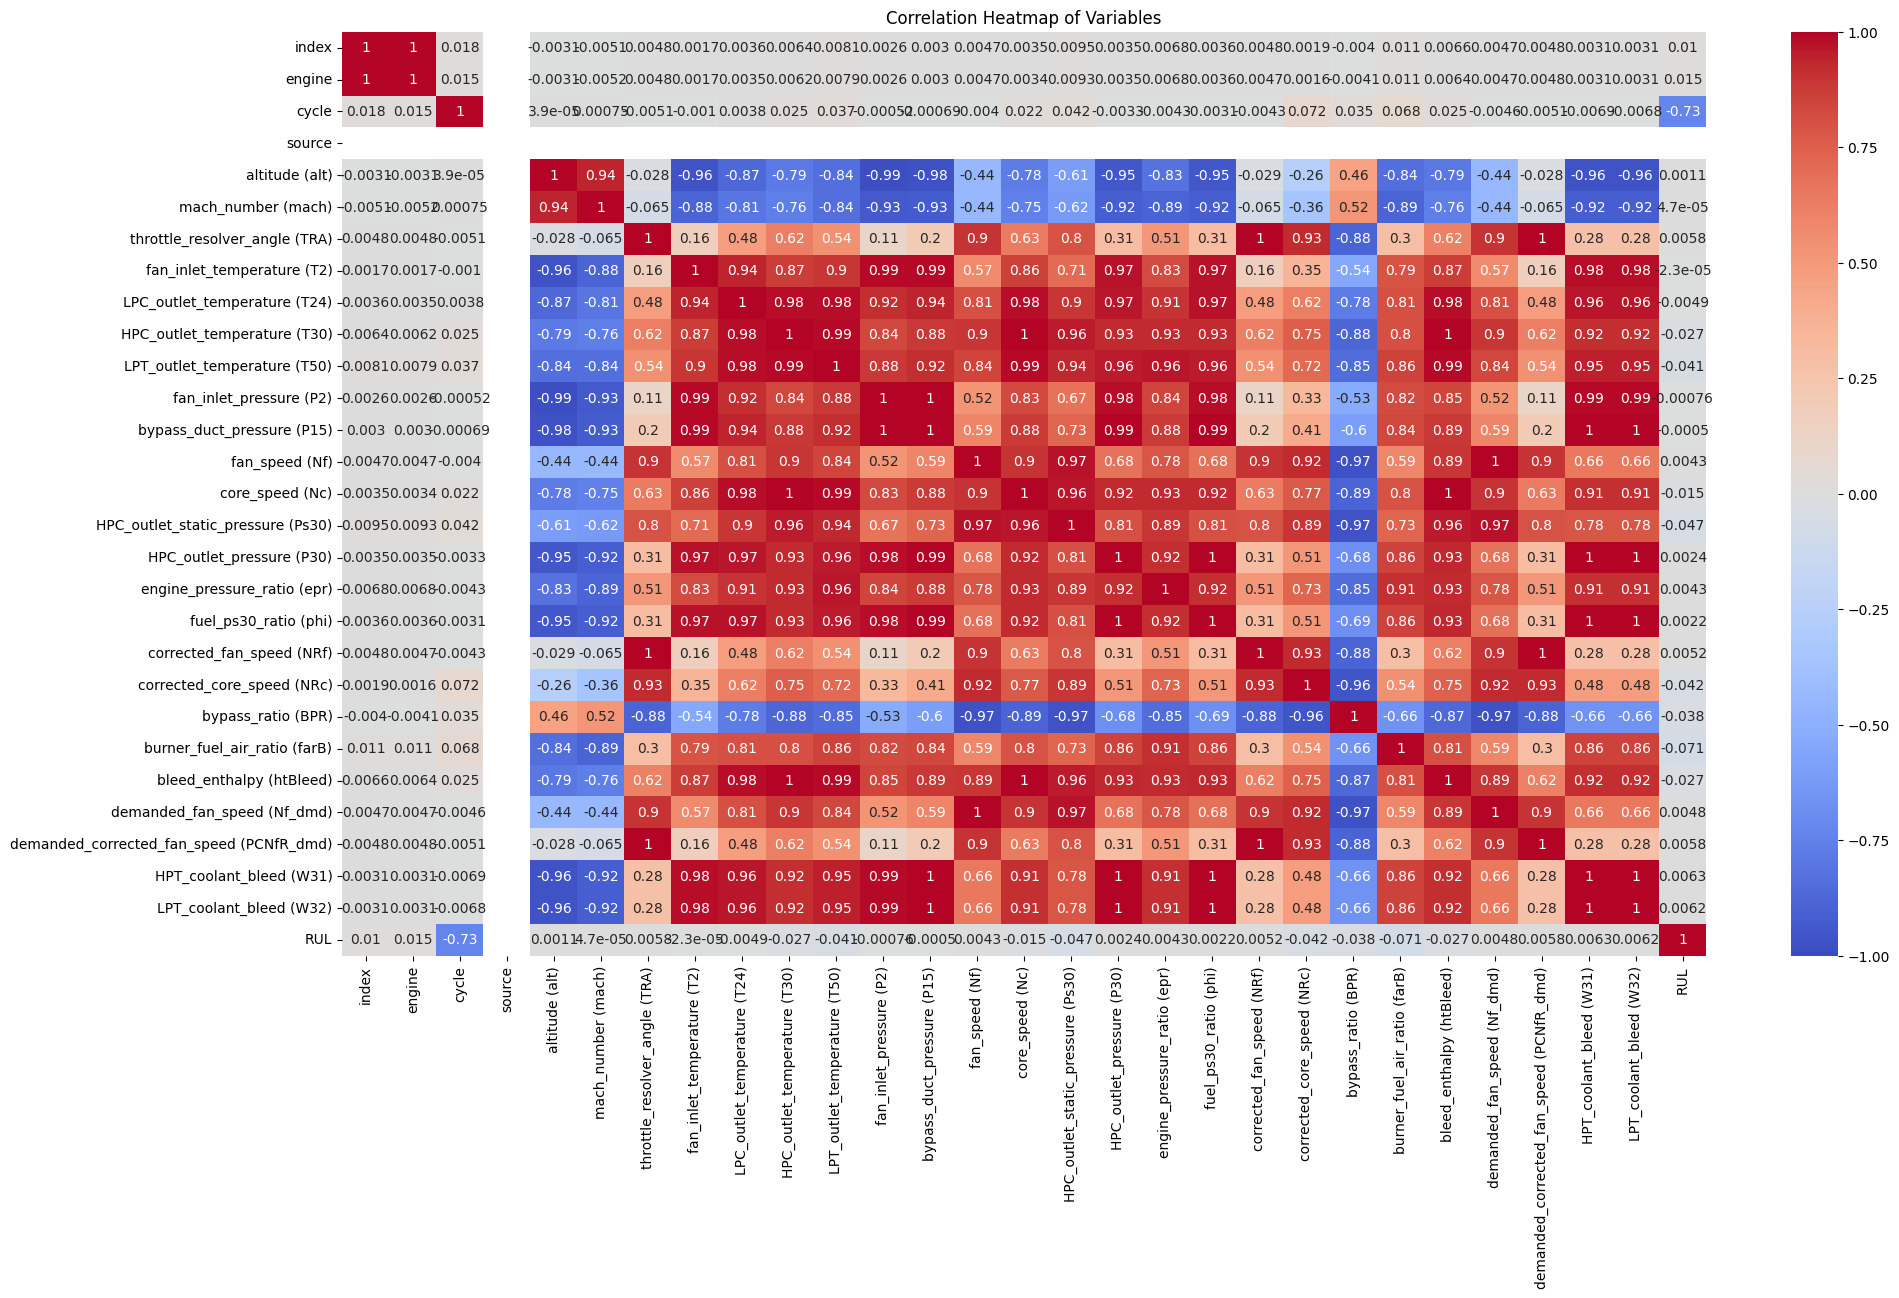

In [15]:
plt.figure(figsize=(22, 12))
corr_matrix = train_df_with_rul.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Variables')
plt.show()